# Advanced Stock Forecasting with LSTM and News Sentiment Analysis

This comprehensive notebook merges LSTM-based stock price forecasting with news sentiment analysis to create an advanced predictive model. The workflow includes:

1. **Automated Stock Selection** from news data
2. **Sentiment Analysis** using FinBERT on news headlines
3. **Feature Engineering** with sentiment scores and technical indicators
4. **Baseline LSTM Model** using only technical indicators
5. **Enhanced LSTM Model** incorporating news sentiment
6. **Performance Comparison** between both models


## 1. Import Required Libraries and Configuration


In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
from datetime import datetime, timedelta
import re

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# NLP Libraries for sentiment analysis
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


## 2. Automated Stock Selection from News Data


In [2]:
def load_and_analyze_news_data(file_path='news_data.csv'):
    """
    Load news data and identify the most frequent stock ticker
    """
    print("Loading news data...")
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print("\nTop 10 most frequent stocks in news:")
    stock_counts = df['stock'].value_counts().head(10)
    print(stock_counts)
    
    # Get the most frequent stock
    target_stock = stock_counts.index[3]
    print(f"\n🎯 Selected target stock: {target_stock} ({stock_counts.iloc[3]} articles)")
    
    return df, target_stock

# Load news data and select target stock
news_df, TARGET_STOCK = load_and_analyze_news_data()


Loading news data...
Dataset shape: (1400469, 4)

Top 10 most frequent stocks in news:
stock
MRK     3334
MS      3242
MU      3144
NVDA    3133
QQQ     3100
M       3078
EBAY    3021
NFLX    3009
GILD    2969
VZ      2937
Name: count, dtype: int64

🎯 Selected target stock: NVDA (3133 articles)


## 3. Sentiment Analysis and Feature Engineering


In [3]:
# Initialize FinBERT model for sentiment analysis
print("Loading FinBERT model...")
finbert_model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name)

def clean_text(text):
    """Clean text for sentiment analysis"""
    if text is None:
        return ""
    text = str(text)
    text = re.sub(r'[^\w\s.]', '', text)
    text = text.lower()
    text = text.replace('.', '_')
    text = text.replace("'s", '')
    text = re.sub(r'[^a-zA-Z\s_]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def analyze_sentiment(description):
    """
    Analyze sentiment using FinBERT
    Returns: 'Positive', 'Negative', 'Neutral', or 'Unknown'
    """
    if not description:
        return 'Unknown'
    
    try:
        cleaned_description = clean_text(description)
        if not cleaned_description:
            return 'Unknown'
        
        inputs = tokenizer(cleaned_description, return_tensors="pt", 
                          padding=True, truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        predicted_class = torch.argmax(predictions, dim=1).item()
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        return sentiment_map[predicted_class]
    
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 'Unknown'

print("FinBERT model loaded successfully!")


Loading FinBERT model...
FinBERT model loaded successfully!


In [4]:
def process_news_sentiment(news_df, target_stock):
    """
    Filter news for target company and process sentiment
    """
    print(f"\n📰 Processing news sentiment for {target_stock}...")

    # Filter news for target company
    company_news = news_df[news_df['stock'] == target_stock].copy()
    print(f"Found {len(company_news)} news articles for {target_stock}")

    if company_news.empty:
        print(f"No news found for {target_stock}")
        return None

    # Clean and parse dates with mixed format handling
    print("Processing dates...")
    company_news['date'] = pd.to_datetime(company_news['date'], utc=True, errors='coerce')
    company_news = company_news.dropna(subset=['date'])
    company_news['Date'] = company_news['date'].dt.date

    print(f"Date range: {company_news['date'].min()} to {company_news['date'].max()}")

    # Apply sentiment analysis to titles
    print("Analyzing sentiment...")
    company_news['Sentiment'] = company_news['title'].apply(analyze_sentiment)

    # Convert sentiment to numerical scores
    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Unknown': 0}
    company_news['Sentiment_Score'] = company_news['Sentiment'].map(sentiment_mapping)

    # Display sentiment distribution
    sentiment_counts = company_news['Sentiment'].value_counts()
    print(f"\nSentiment Distribution:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(company_news)) * 100
        print(f"  {sentiment}: {count} ({percentage:.1f}%)")

    return company_news

# Process sentiment for target company
company_sentiment_df = process_news_sentiment(news_df, TARGET_STOCK)



📰 Processing news sentiment for NVDA...
Found 3133 news articles for NVDA
Processing dates...
Date range: 2011-03-03 15:06:00+00:00 to 2020-06-10 16:37:00+00:00
Analyzing sentiment...

Sentiment Distribution:
  Positive: 1774 (56.6%)
  Negative: 726 (23.2%)
  Neutral: 633 (20.2%)


In [5]:
def aggregate_daily_sentiment(sentiment_df):
    """
    Aggregate sentiment scores on a daily basis
    """
    if sentiment_df is None or sentiment_df.empty:
        return None
    
    print("\n📊 Aggregating daily sentiment scores...")
    
    # Group by date and calculate daily sentiment metrics
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'Sentiment_Score': ['mean', 'sum', 'count'],
        'Sentiment': lambda x: (x == 'Positive').sum(),  # Count of positive news
    }).round(4)
    
    # Flatten column names
    daily_sentiment.columns = ['Avg_Sentiment', 'Total_Sentiment', 'News_Count', 'Positive_Count']
    
    # Calculate additional metrics
    daily_sentiment['Negative_Count'] = sentiment_df.groupby('Date')['Sentiment'].apply(
        lambda x: (x == 'Negative').sum()
    )
    daily_sentiment['Neutral_Count'] = sentiment_df.groupby('Date')['Sentiment'].apply(
        lambda x: (x == 'Neutral').sum()
    )
    
    # Calculate sentiment ratio (positive - negative) / total
    daily_sentiment['Sentiment_Ratio'] = (
        (daily_sentiment['Positive_Count'] - daily_sentiment['Negative_Count']) / 
        daily_sentiment['News_Count']
    ).fillna(0)
    
    print(f"Daily sentiment data shape: {daily_sentiment.shape}")
    print(f"Date range: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")
    
    return daily_sentiment

# Aggregate daily sentiment
daily_sentiment_df = aggregate_daily_sentiment(company_sentiment_df)

if daily_sentiment_df is not None:
    print("\nSample daily sentiment data:")
    print(daily_sentiment_df.head(10))



📊 Aggregating daily sentiment scores...
Daily sentiment data shape: (1195, 7)
Date range: 2011-03-03 to 2020-06-10

Sample daily sentiment data:
            Avg_Sentiment  Total_Sentiment  News_Count  Positive_Count  \
Date                                                                     
2011-03-03         0.0000                0           1               0   
2011-03-07         1.0000                2           2               2   
2011-03-08         0.2500                1           4               2   
2011-03-09         1.0000                3           3               3   
2011-03-10         1.0000                2           2               2   
2011-03-15         0.6667                2           3               2   
2011-03-16         0.6667                2           3               2   
2011-03-23         1.0000                1           1               1   
2011-03-24         1.0000                1           1               1   
2011-03-25         1.0000               

## 4. Dynamic Date Range Calculation


In [6]:
def calculate_dynamic_date_range(daily_sentiment_df):
    """
    Calculate dynamic date range based on news data
    """
    if daily_sentiment_df is None or daily_sentiment_df.empty:
        print("No sentiment data available for date range calculation")
        return None, None
    
    # Get earliest and latest news dates
    earliest_news_date = daily_sentiment_df.index.min()
    latest_news_date = daily_sentiment_df.index.max()
    
    # Set START_DATE to one year before earliest news date
    start_date = earliest_news_date - pd.DateOffset(years=1)
    
    print(f"\n📅 Dynamic Date Range Calculation:")
    print(f"Earliest news date: {earliest_news_date}")
    print(f"Latest news date: {latest_news_date}")
    print(f"LSTM START_DATE (1 year before): {start_date.strftime('%Y-%m-%d')}")
    print(f"LSTM END_DATE: {latest_news_date.strftime('%Y-%m-%d')}")
    
    return start_date.strftime('%Y-%m-%d'), latest_news_date.strftime('%Y-%m-%d')

# Calculate dynamic date range
START_DATE, END_DATE = calculate_dynamic_date_range(daily_sentiment_df)

# Model Parameters
SEQUENCE_LENGTH = 30  # Number of days to look back for prediction
TEST_SIZE = 0.2      # Proportion of data for testing
EPOCHS = 50          # Number of training epochs
BATCH_SIZE = 32      # Batch size for training

print(f"\n🎯 Analysis Configuration:")
print(f"Target Stock: {TARGET_STOCK}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Sequence Length: {SEQUENCE_LENGTH} days")
print(f"Test Size: {TEST_SIZE}")



📅 Dynamic Date Range Calculation:
Earliest news date: 2011-03-03
Latest news date: 2020-06-10
LSTM START_DATE (1 year before): 2010-03-03
LSTM END_DATE: 2020-06-10

🎯 Analysis Configuration:
Target Stock: NVDA
Date Range: 2010-03-03 to 2020-06-10
Sequence Length: 30 days
Test Size: 0.2


## 5. Report 1: Baseline LSTM Model (Technical Indicators Only)

This section implements the baseline LSTM model using only historical price data and technical indicators, without news sentiment.


In [7]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data using yfinance
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, interval='1d')
        
        if data.empty:
            raise ValueError(f"No data found for ticker {ticker}")
        
        print(f"Successfully fetched {len(data)} days of data for {ticker}")
        print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
        
        return data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def calculate_technical_indicators(data):
    """
    Calculate technical indicators for enhanced feature set
    """
    df = data.copy()
    
    # 7-day Simple Moving Average
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    
    # Relative Strength Index (RSI)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI'] = calculate_rsi(df['Close'])
    
    # Price change percentage
    df['Price_Change_Pct'] = df['Close'].pct_change()
    
    # Volume moving average
    df['Volume_MA'] = df['Volume'].rolling(window=7).mean()
    
    # High-Low spread
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']
    
    return df

# Fetch stock data
print(f"\n📈 Fetching stock data for {TARGET_STOCK}...")
stock_data = fetch_stock_data(TARGET_STOCK, START_DATE, END_DATE)

if stock_data is not None:
    # Calculate technical indicators
    enhanced_data = calculate_technical_indicators(stock_data)
    enhanced_data = enhanced_data.dropna()
    
    print(f"Enhanced dataset shape: {enhanced_data.shape}")
    print("\nTechnical indicators calculated:")
    print(enhanced_data[['Close', 'SMA_7', 'RSI', 'Price_Change_Pct', 'HL_Spread']].head())



📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data for NVDA
Date range: 2010-03-03 to 2020-06-09
Enhanced dataset shape: (2573, 12)

Technical indicators calculated:
                              Close     SMA_7        RSI  Price_Change_Pct  \
Date                                                                         
2010-03-22 00:00:00-04:00  0.401848  0.401193  61.029443          0.016232   
2010-03-23 00:00:00-04:00  0.410100  0.403289  64.189195          0.020536   
2010-03-24 00:00:00-04:00  0.396346  0.403714  56.287363         -0.033538   
2010-03-25 00:00:00-04:00  0.397492  0.402339  51.868147          0.002892   
2010-03-26 00:00:00-04:00  0.397492  0.399850  54.883729          0.000000   

                           HL_Spread  
Date                                  
2010-03-22 00:00:00-04:00   0.032516  
2010-03-23 00:00:00-04:00   0.024595  
2010-03-24 00:00:00-04:00   0.030654  
2010-03-25 00:00:00-04:00   0.020185  
2010-03-26 00:00:00-04:00   0.

In [8]:
def prepare_lstm_data(data, sequence_length, test_size):
    """
    Prepare data for LSTM training with multiple features
    """
    # Select features for the model
    feature_columns = ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']
    features = data[feature_columns].values
    
    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])  # All features for sequence
        y.append(scaled_features[i, 0])  # Only Close price as target
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets
    split_index = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test, scaler, feature_columns

def build_lstm_model(input_shape):
    """
    Build a stacked LSTM model with dropout layers for regularization
    """
    model = Sequential([
        # First LSTM layer with return_sequences=True to stack layers
        LSTM(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(units=100, return_sequences=True),
        Dropout(0.2),
        
        # Third LSTM layer (final layer doesn't return sequences)
        LSTM(units=50),
        Dropout(0.2),
        
        # Dense output layer
        Dense(units=1, activation='linear')
    ])
    
    # Compile with Adam optimizer and MSE loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Prepare baseline data (technical indicators only)
print("\n🔧 Preparing baseline LSTM data...")
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline, scaler_baseline, feature_names_baseline = prepare_lstm_data(
    enhanced_data, SEQUENCE_LENGTH, TEST_SIZE
)

print(f"Baseline Training data shape: X_train: {X_train_baseline.shape}, y_train: {y_train_baseline.shape}")
print(f"Baseline Testing data shape: X_test: {X_test_baseline.shape}, y_test: {y_test_baseline.shape}")
print(f"Features used: {feature_names_baseline}")

# Build baseline model
print("\n🏗️ Building baseline LSTM model...")
baseline_model = build_lstm_model((X_train_baseline.shape[1], X_train_baseline.shape[2]))
print("Baseline LSTM Model Architecture:")
baseline_model.summary()



🔧 Preparing baseline LSTM data...
Baseline Training data shape: X_train: (2034, 30, 5), y_train: (2034,)
Baseline Testing data shape: X_test: (509, 30, 5), y_test: (509,)
Features used: ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']

🏗️ Building baseline LSTM model...
Baseline LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,051 (597.86 KB)

 Trainable params: 153,051 (597.86 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train baseline model
print("\n🚀 Training baseline LSTM model...")

# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train the baseline model
baseline_history = baseline_model.fit(
    X_train_baseline, y_train_baseline,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Baseline model training completed!")



🚀 Training baseline LSTM model...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0019 - mae: 0.0304 - val_loss: 0.0014 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.2495e-05 - mae: 0.0064 - val_loss: 9.0208e-04 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.2681e-05 - mae: 0.0053 - val_loss: 0.0014 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.1192e-05 - mae: 0.0052 - val_loss: 9.3967e-04 - val_mae: 0.0241 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.8997e-05 - mae: 0.0048 - val_loss: 8.9674e-04 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.4684e-05 - mae: 0.0047 - val_loss: 9.9401e-04 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.9576e-05 - mae: 0.0045

In [10]:
def calculate_metrics(actual, predicted, model_name):
    """
    Calculate comprehensive performance metrics
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional Accuracy
    actual_direction = np.diff(actual.flatten()) > 0
    predicted_direction = np.diff(predicted.flatten()) > 0
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }

# Make baseline predictions
print("\n📊 Evaluating baseline model...")
baseline_train_predictions = baseline_model.predict(X_train_baseline, verbose=0)
baseline_test_predictions = baseline_model.predict(X_test_baseline, verbose=0)

# Create a scaler for inverse transformation (only for Close price)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(enhanced_data[['Close']].values)

# Inverse transform predictions and actual values
baseline_train_predictions_scaled = close_scaler.inverse_transform(baseline_train_predictions)
baseline_test_predictions_scaled = close_scaler.inverse_transform(baseline_test_predictions.reshape(-1, 1))
y_train_baseline_scaled = close_scaler.inverse_transform(y_train_baseline.reshape(-1, 1))
y_test_baseline_scaled = close_scaler.inverse_transform(y_test_baseline.reshape(-1, 1))

# Create naive baseline predictions (tomorrow = today)
naive_predictions = np.roll(y_test_baseline_scaled, 1)
naive_predictions[0] = y_test_baseline_scaled[0]

# Calculate metrics
baseline_lstm_metrics = calculate_metrics(y_test_baseline_scaled, baseline_test_predictions_scaled, 'Baseline LSTM')
naive_baseline_metrics = calculate_metrics(y_test_baseline_scaled, naive_predictions, 'Naive Baseline')

print("\n" + "="*60)
print("📈 REPORT 1: STOCK FORECAST USING TECHNICAL INDICATORS ONLY")
print("="*60)

# Create comparison DataFrame
baseline_metrics_df = pd.DataFrame([baseline_lstm_metrics, naive_baseline_metrics])
baseline_metrics_df = baseline_metrics_df.round(4)

print("\n📊 PERFORMANCE COMPARISON")
print("-" * 50)
print(baseline_metrics_df.to_string(index=False))

# Calculate improvement over naive baseline
rmse_improvement_baseline = ((naive_baseline_metrics['RMSE'] - baseline_lstm_metrics['RMSE']) / naive_baseline_metrics['RMSE']) * 100
directional_improvement_baseline = baseline_lstm_metrics['Directional_Accuracy'] - naive_baseline_metrics['Directional_Accuracy']

print(f"\n📈 MODEL EFFECTIVENESS")
print("-" * 30)
print(f"RMSE Improvement over Naive Baseline: {rmse_improvement_baseline:.2f}%")
print(f"Directional Accuracy Improvement: {directional_improvement_baseline:.2f} percentage points")

if rmse_improvement_baseline > 10:
    print("✅ Baseline LSTM shows significant improvement over naive baseline")
elif rmse_improvement_baseline > 0:
    print("✅ Baseline LSTM shows modest improvement over naive baseline")
else:
    print("⚠️  Baseline LSTM does not outperform naive baseline")



📊 Evaluating baseline model...

📈 REPORT 1: STOCK FORECAST USING TECHNICAL INDICATORS ONLY

📊 PERFORMANCE COMPARISON
--------------------------------------------------
         Model   RMSE    MAE   MAPE  Directional_Accuracy
 Baseline LSTM 0.5391 0.3784 7.2403               50.3937
Naive Baseline 0.1799 0.1213 2.3195               43.5039

📈 MODEL EFFECTIVENESS
------------------------------
RMSE Improvement over Naive Baseline: -199.63%
Directional Accuracy Improvement: 6.89 percentage points
⚠️  Baseline LSTM does not outperform naive baseline



📊 Creating baseline model visualizations...


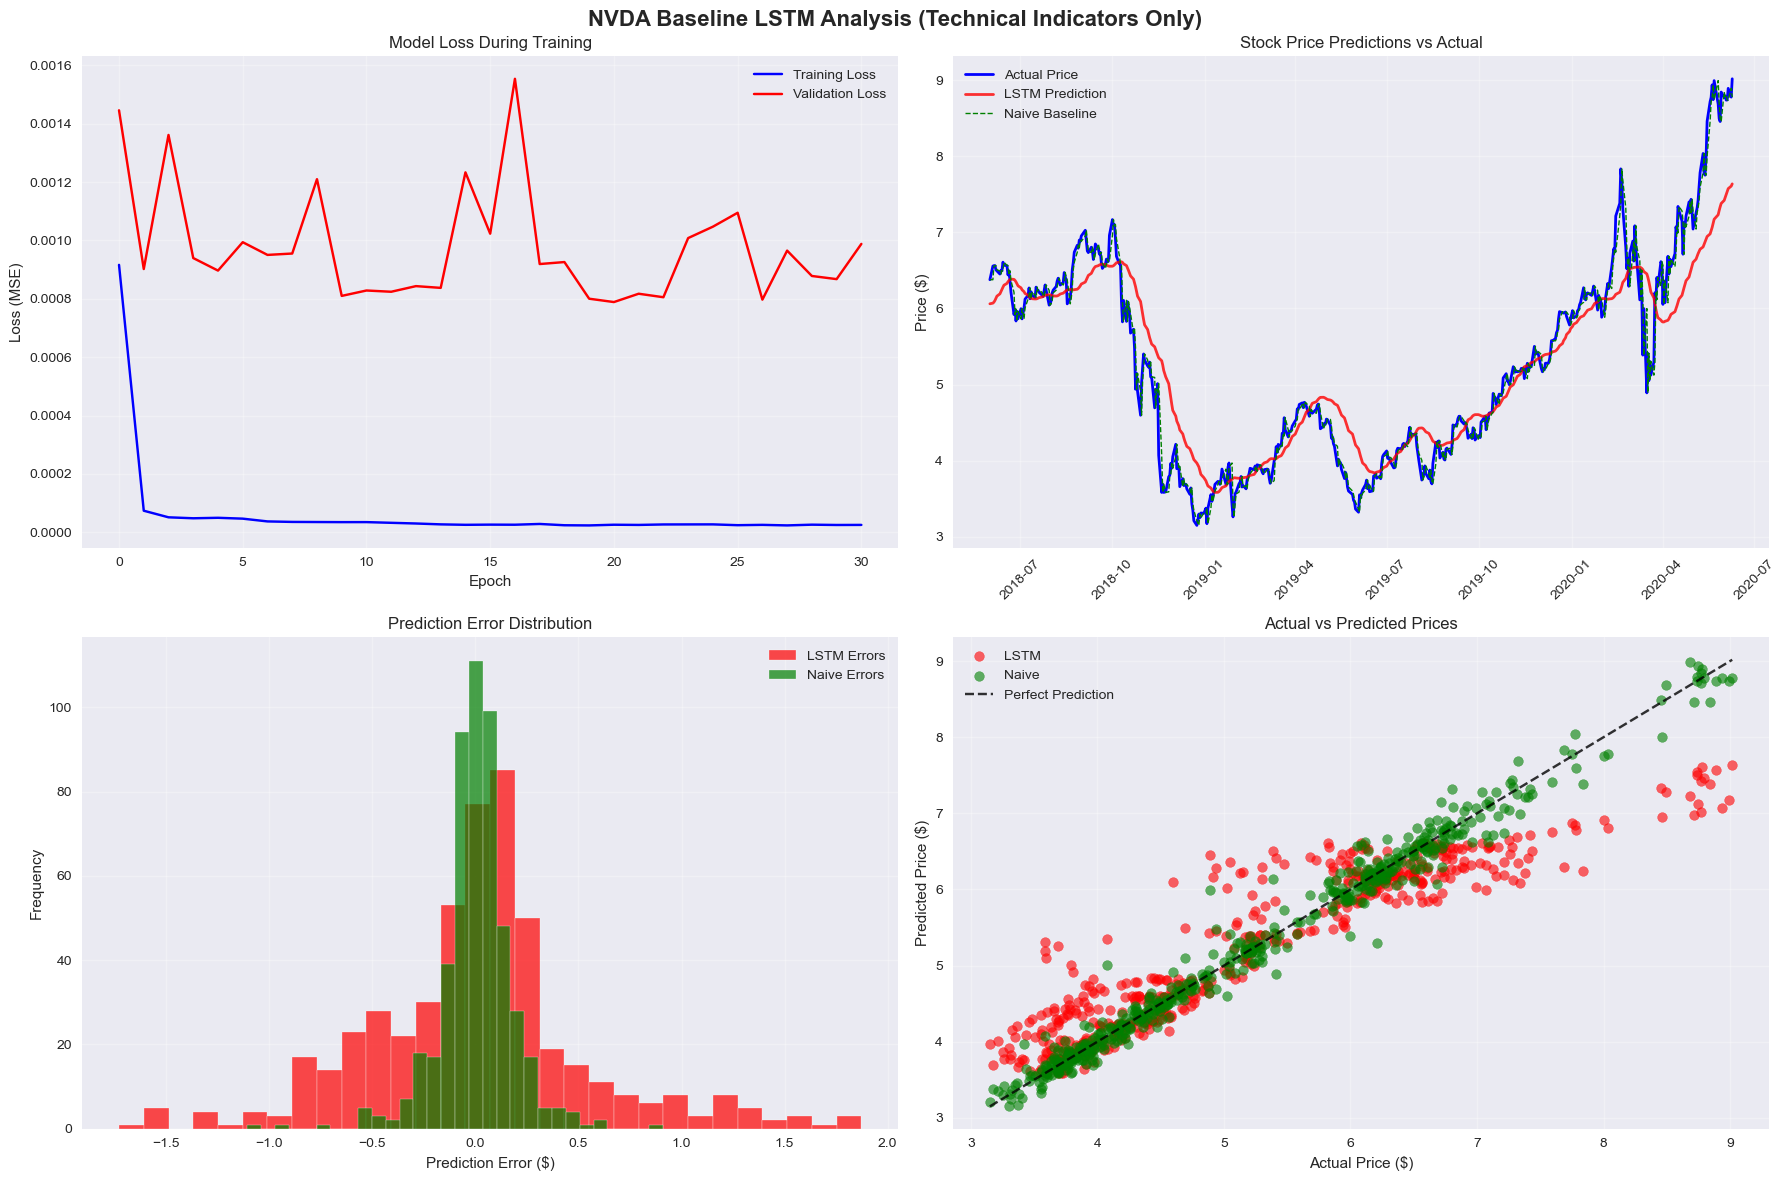


✅ Report 1 completed for NVDA
Baseline LSTM RMSE: $0.54
Baseline LSTM Directional Accuracy: 50.4%


In [11]:
# Visualization for baseline model
print("\n📊 Creating baseline model visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'{TARGET_STOCK} Baseline LSTM Analysis (Technical Indicators Only)', fontsize=16, fontweight='bold')

# 1. Training history
axes[0, 0].plot(baseline_history.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(baseline_history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Model Loss During Training')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Predictions vs Actual
test_dates = enhanced_data.index[-len(y_test_baseline_scaled):]
axes[0, 1].plot(test_dates, y_test_baseline_scaled, label='Actual Price', color='blue', linewidth=2)
axes[0, 1].plot(test_dates, baseline_test_predictions_scaled, label='LSTM Prediction', color='red', linewidth=2, alpha=0.8)
axes[0, 1].plot(test_dates, naive_predictions, label='Naive Baseline', color='green', linewidth=1, linestyle='--')
axes[0, 1].set_title('Stock Price Predictions vs Actual')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Prediction errors
lstm_errors = y_test_baseline_scaled.flatten() - baseline_test_predictions_scaled.flatten()
naive_errors = y_test_baseline_scaled.flatten() - naive_predictions.flatten()

axes[1, 0].hist(lstm_errors, bins=30, alpha=0.7, label='LSTM Errors', color='red')
axes[1, 0].hist(naive_errors, bins=30, alpha=0.7, label='Naive Errors', color='green')
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter plot: Actual vs Predicted
axes[1, 1].scatter(y_test_baseline_scaled, baseline_test_predictions_scaled, alpha=0.6, color='red', label='LSTM')
axes[1, 1].scatter(y_test_baseline_scaled, naive_predictions, alpha=0.6, color='green', label='Naive')
min_price = min(y_test_baseline_scaled.min(), baseline_test_predictions_scaled.min())
max_price = max(y_test_baseline_scaled.max(), baseline_test_predictions_scaled.max())
axes[1, 1].plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, label='Perfect Prediction')
axes[1, 1].set_title('Actual vs Predicted Prices')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Report 1 completed for {TARGET_STOCK}")
print(f"Baseline LSTM RMSE: ${baseline_lstm_metrics['RMSE']:.2f}")
print(f"Baseline LSTM Directional Accuracy: {baseline_lstm_metrics['Directional_Accuracy']:.1f}%")


## 6. Report 2: Sentiment-Enhanced LSTM Model

This section implements the enhanced LSTM model that incorporates news sentiment as an additional predictive feature alongside technical indicators.


In [12]:
def create_enhanced_dataset(stock_data, daily_sentiment_df):
    """
    Create enhanced dataset by merging stock data with daily sentiment scores
    """
    print("\n🔗 Creating sentiment-enhanced dataset...")
    
    if daily_sentiment_df is None or daily_sentiment_df.empty:
        print("No sentiment data available for enhancement")
        return None
    
    # Create a copy of stock data
    enhanced_stock_data = stock_data.copy()
    
    # Convert stock data index to date for merging
    enhanced_stock_data['Date'] = enhanced_stock_data.index.date
    enhanced_stock_data = enhanced_stock_data.set_index('Date')
    
    # Merge with sentiment data
    merged_data = enhanced_stock_data.join(daily_sentiment_df, how='left')
    
    # Handle missing sentiment data
    print("Handling missing sentiment data...")
    
    # Forward fill sentiment scores for days with no news
    sentiment_columns = ['Avg_Sentiment', 'Total_Sentiment', 'News_Count', 
                        'Positive_Count', 'Negative_Count', 'Neutral_Count', 'Sentiment_Ratio']
    
    for col in sentiment_columns:
        if col in merged_data.columns:
            # Forward fill first, then backward fill for any remaining NaN at the beginning
            merged_data[col] = merged_data[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Reset index to datetime for consistency
    merged_data.index = pd.to_datetime(merged_data.index)
    
    print(f"Enhanced dataset shape: {merged_data.shape}")
    print(f"Sentiment columns added: {[col for col in sentiment_columns if col in merged_data.columns]}")
    
    # Display sample of enhanced data
    print("\nSample enhanced data:")
    display_cols = ['Close', 'SMA_7', 'RSI', 'Avg_Sentiment', 'News_Count', 'Sentiment_Ratio']
    available_cols = [col for col in display_cols if col in merged_data.columns]
    print(merged_data[available_cols].head(10))
    
    return merged_data

# Create enhanced dataset
enhanced_stock_data = create_enhanced_dataset(enhanced_data, daily_sentiment_df)



🔗 Creating sentiment-enhanced dataset...
Handling missing sentiment data...
Enhanced dataset shape: (2573, 19)
Sentiment columns added: ['Avg_Sentiment', 'Total_Sentiment', 'News_Count', 'Positive_Count', 'Negative_Count', 'Neutral_Count', 'Sentiment_Ratio']

Sample enhanced data:
               Close     SMA_7        RSI  Avg_Sentiment  News_Count  \
Date                                                                   
2010-03-22  0.401848  0.401193  61.029443            0.0         1.0   
2010-03-23  0.410100  0.403289  64.189195            0.0         1.0   
2010-03-24  0.396346  0.403714  56.287363            0.0         1.0   
2010-03-25  0.397492  0.402339  51.868147            0.0         1.0   
2010-03-26  0.397492  0.399850  54.883729            0.0         1.0   
2010-03-29  0.402536  0.400178  50.128638            0.0         1.0   
2010-03-30  0.404140  0.401422  50.510117            0.0         1.0   
2010-03-31  0.398868  0.400996  52.800006            0.0         1.0 

In [13]:
def prepare_enhanced_lstm_data(data, sequence_length, test_size):
    """
    Prepare enhanced data for LSTM training with sentiment features
    """
    if data is None:
        return None, None, None, None, None, None
    
    # Select features including sentiment
    base_features = ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread']
    sentiment_features = ['Avg_Sentiment', 'Sentiment_Ratio', 'News_Count']
    
    # Check which sentiment features are available
    available_sentiment_features = [col for col in sentiment_features if col in data.columns]
    feature_columns = base_features + available_sentiment_features
    
    print(f"Enhanced features: {feature_columns}")
    
    # Extract features
    features = data[feature_columns].values
    
    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])  # All features for sequence
        y.append(scaled_features[i, 0])  # Only Close price as target
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets
    split_index = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test, scaler, feature_columns

# Prepare enhanced data
if enhanced_stock_data is not None:
    print("\n🔧 Preparing enhanced LSTM data...")
    X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced, scaler_enhanced, feature_names_enhanced = prepare_enhanced_lstm_data(
        enhanced_stock_data, SEQUENCE_LENGTH, TEST_SIZE
    )
    
    if X_train_enhanced is not None:
        print(f"Enhanced Training data shape: X_train: {X_train_enhanced.shape}, y_train: {y_train_enhanced.shape}")
        print(f"Enhanced Testing data shape: X_test: {X_test_enhanced.shape}, y_test: {y_test_enhanced.shape}")
        print(f"Enhanced features used: {feature_names_enhanced}")
        
        # Build enhanced model
        print("\n🏗️ Building sentiment-enhanced LSTM model...")
        enhanced_model = build_lstm_model((X_train_enhanced.shape[1], X_train_enhanced.shape[2]))
        print("Enhanced LSTM Model Architecture:")
        enhanced_model.summary()
    else:
        print("Failed to prepare enhanced data")
        enhanced_model = None
else:
    print("No enhanced stock data available")
    enhanced_model = None



🔧 Preparing enhanced LSTM data...
Enhanced features: ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread', 'Avg_Sentiment', 'Sentiment_Ratio', 'News_Count']
Enhanced Training data shape: X_train: (2034, 30, 8), y_train: (2034,)
Enhanced Testing data shape: X_test: (509, 30, 8), y_test: (509,)
Enhanced features used: ['Close', 'SMA_7', 'RSI', 'Volume', 'HL_Spread', 'Avg_Sentiment', 'Sentiment_Ratio', 'News_Count']

🏗️ Building sentiment-enhanced LSTM model...
Enhanced LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,251 (602.54 KB)

 Trainable params: 154,251 (602.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train enhanced model
if enhanced_model is not None and X_train_enhanced is not None:
    print("\n🚀 Training sentiment-enhanced LSTM model...")
    
    # Train the enhanced model
    enhanced_history = enhanced_model.fit(
        X_train_enhanced, y_train_enhanced,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Enhanced model training completed!")
    
    # Make enhanced predictions
    print("\n📊 Evaluating enhanced model...")
    enhanced_train_predictions = enhanced_model.predict(X_train_enhanced, verbose=0)
    enhanced_test_predictions = enhanced_model.predict(X_test_enhanced, verbose=0)
    
    # Inverse transform predictions and actual values
    enhanced_train_predictions_scaled = close_scaler.inverse_transform(enhanced_train_predictions)
    enhanced_test_predictions_scaled = close_scaler.inverse_transform(enhanced_test_predictions.reshape(-1, 1))
    y_train_enhanced_scaled = close_scaler.inverse_transform(y_train_enhanced.reshape(-1, 1))
    y_test_enhanced_scaled = close_scaler.inverse_transform(y_test_enhanced.reshape(-1, 1))
    
    # Calculate metrics for enhanced model
    enhanced_lstm_metrics = calculate_metrics(y_test_enhanced_scaled, enhanced_test_predictions_scaled, 'Enhanced LSTM')
    
    print("\n" + "="*70)
    print("📈 REPORT 2: STOCK FORECAST USING TECHNICAL INDICATORS AND NEWS SENTIMENT")
    print("="*70)
    
    # Create comprehensive comparison DataFrame
    all_metrics_df = pd.DataFrame([baseline_lstm_metrics, enhanced_lstm_metrics, naive_baseline_metrics])
    all_metrics_df = all_metrics_df.round(4)
    
    print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
    print("-" * 60)
    print(all_metrics_df.to_string(index=False))
    
    # Calculate improvements
    rmse_improvement_enhanced = ((baseline_lstm_metrics['RMSE'] - enhanced_lstm_metrics['RMSE']) / baseline_lstm_metrics['RMSE']) * 100
    directional_improvement_enhanced = enhanced_lstm_metrics['Directional_Accuracy'] - baseline_lstm_metrics['Directional_Accuracy']
    
    print(f"\n📈 SENTIMENT ENHANCEMENT EFFECTIVENESS")
    print("-" * 40)
    print(f"RMSE Improvement over Baseline LSTM: {rmse_improvement_enhanced:.2f}%")
    print(f"Directional Accuracy Improvement: {directional_improvement_enhanced:.2f} percentage points")
    
    # Overall comparison with naive baseline
    rmse_improvement_vs_naive = ((naive_baseline_metrics['RMSE'] - enhanced_lstm_metrics['RMSE']) / naive_baseline_metrics['RMSE']) * 100
    directional_improvement_vs_naive = enhanced_lstm_metrics['Directional_Accuracy'] - naive_baseline_metrics['Directional_Accuracy']
    
    print(f"\n📈 ENHANCED MODEL vs NAIVE BASELINE")
    print("-" * 40)
    print(f"RMSE Improvement over Naive Baseline: {rmse_improvement_vs_naive:.2f}%")
    print(f"Directional Accuracy Improvement: {directional_improvement_vs_naive:.2f} percentage points")
    
    # Determine effectiveness
    if rmse_improvement_enhanced > 5:
        print("\n✅ SIGNIFICANT IMPROVEMENT: News sentiment significantly enhances prediction accuracy")
    elif rmse_improvement_enhanced > 0:
        print("\n✅ MODEST IMPROVEMENT: News sentiment provides modest enhancement")
    elif rmse_improvement_enhanced > -2:
        print("\n⚠️  MINIMAL IMPACT: News sentiment has minimal impact on prediction accuracy")
    else:
        print("\n❌ NEGATIVE IMPACT: News sentiment appears to hurt prediction accuracy")

else:
    print("Enhanced model training skipped due to data preparation issues")
    enhanced_lstm_metrics = None
    enhanced_test_predictions_scaled = None
    y_test_enhanced_scaled = None



🚀 Training sentiment-enhanced LSTM model...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0034 - mae: 0.0421 - val_loss: 0.0920 - val_mae: 0.2823 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.2536e-04 - mae: 0.0121 - val_loss: 0.0028 - val_mae: 0.0413 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.7429e-05 - mae: 0.0070 - val_loss: 0.0023 - val_mae: 0.0366 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.8096e-05 - mae: 0.0066 - val_loss: 0.0029 - val_mae: 0.0421 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.6153e-05 - mae: 0.0061 - val_loss: 0.0027 - val_mae: 0.0396 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.2998e-05 - mae: 0.0054 - val_loss: 0.0035 - val_mae: 0.0455 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.3987e-05 - mae: 0.0063 - val


📊 Creating comprehensive model comparison visualizations...


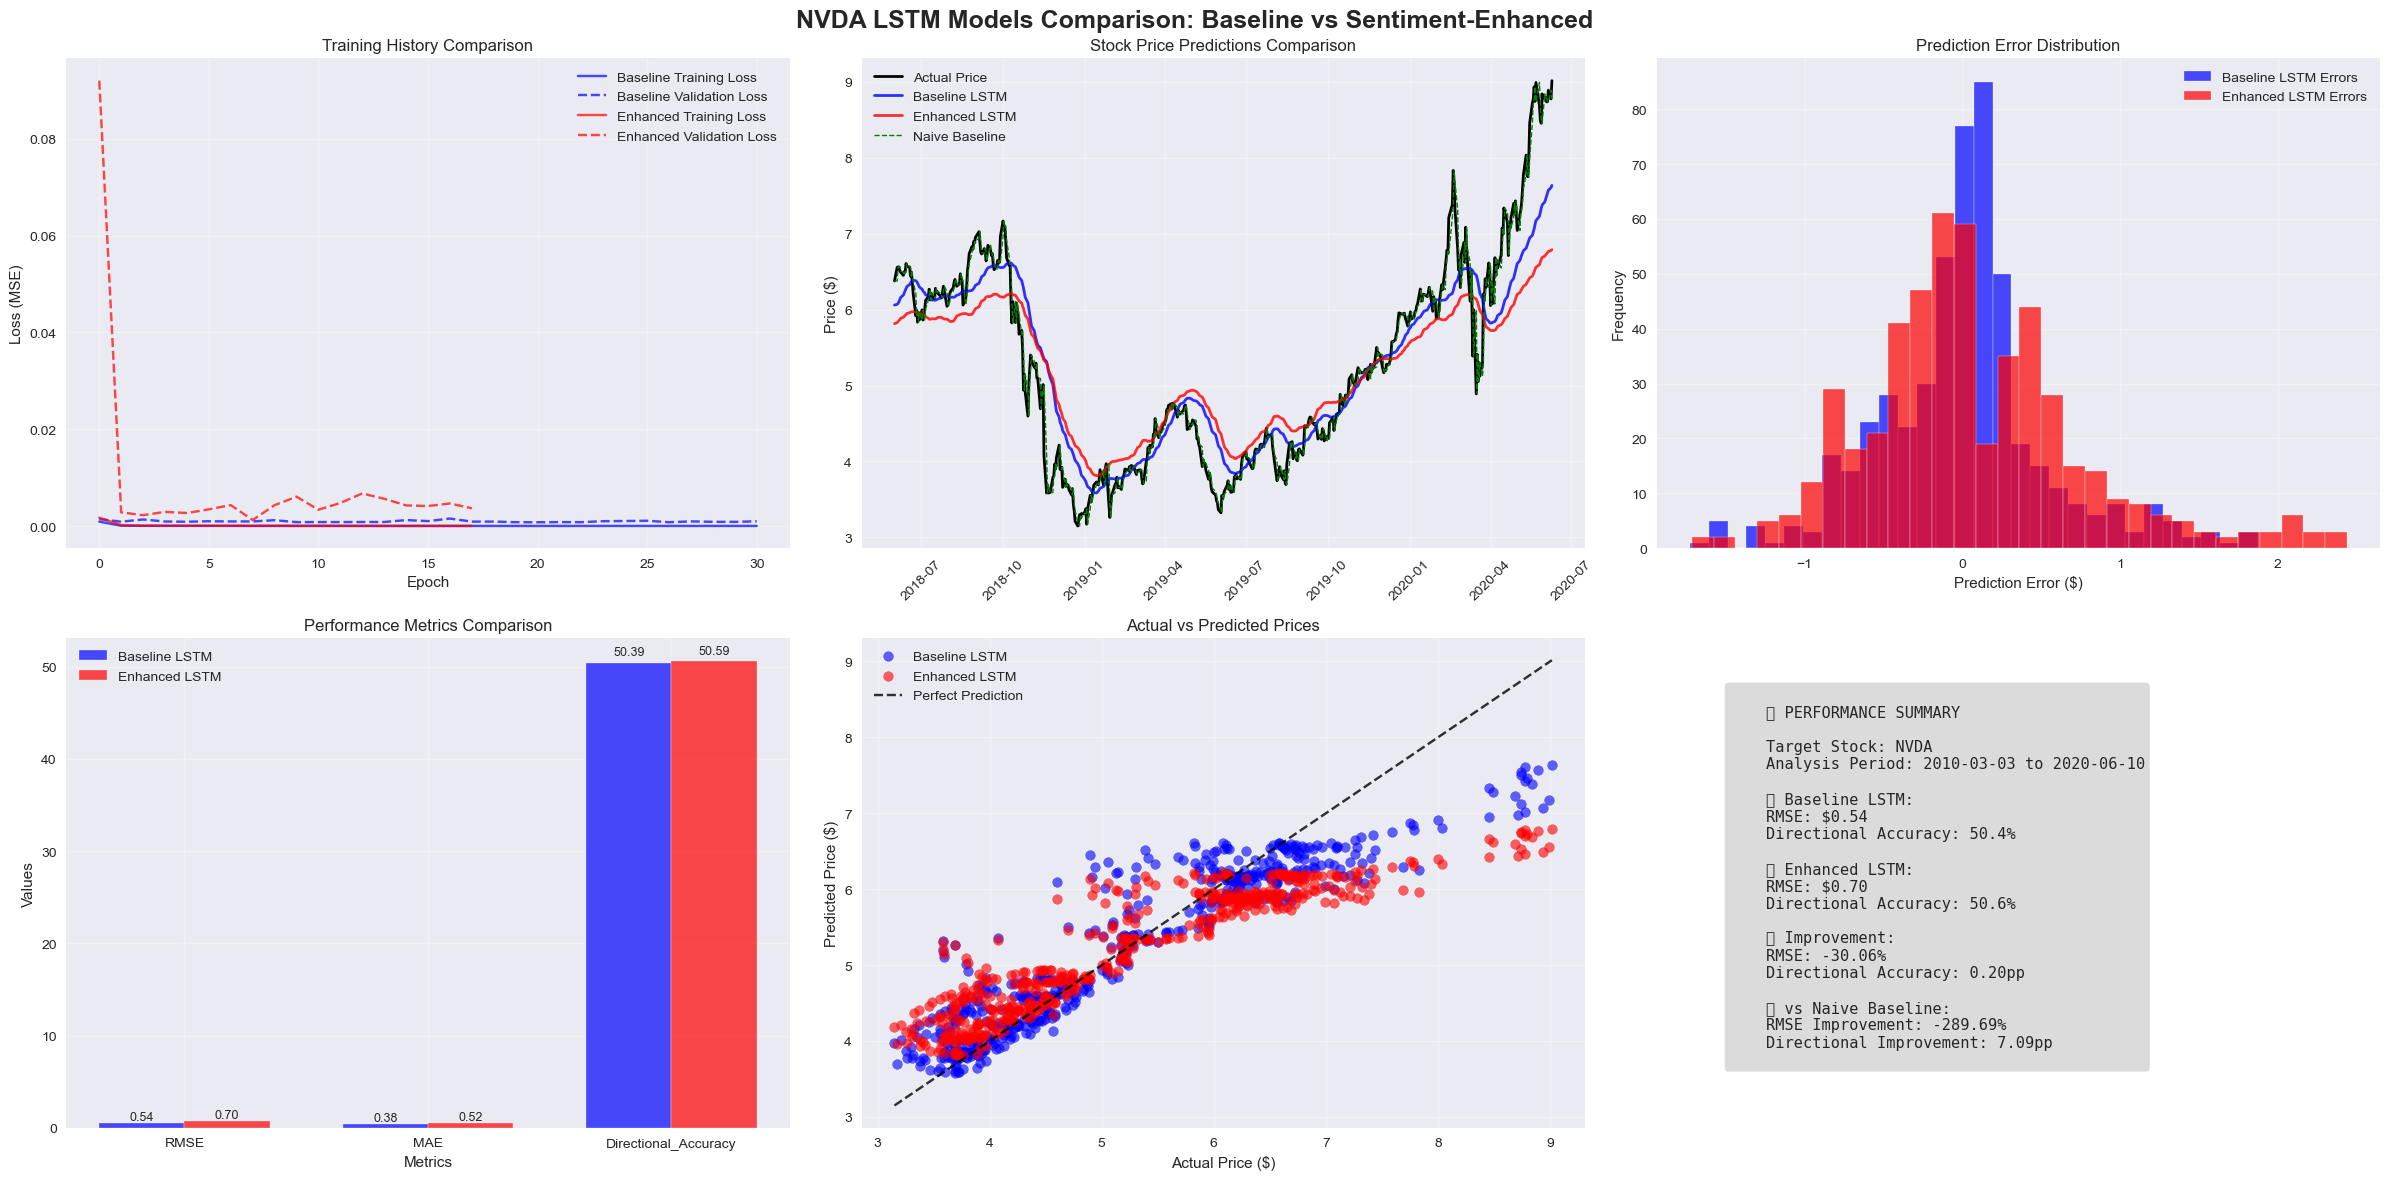


✅ Report 2 completed for NVDA
Enhanced LSTM RMSE: $0.70
Enhanced LSTM Directional Accuracy: 50.6%


In [15]:
# Comprehensive visualization comparing both models
if enhanced_model is not None and enhanced_test_predictions_scaled is not None:
    print("\n📊 Creating comprehensive model comparison visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle(f'{TARGET_STOCK} LSTM Models Comparison: Baseline vs Sentiment-Enhanced', fontsize=18, fontweight='bold')
    
    # 1. Training history comparison
    axes[0, 0].plot(baseline_history.history['loss'], label='Baseline Training Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(baseline_history.history['val_loss'], label='Baseline Validation Loss', color='blue', linestyle='--', alpha=0.7)
    axes[0, 0].plot(enhanced_history.history['loss'], label='Enhanced Training Loss', color='red', alpha=0.7)
    axes[0, 0].plot(enhanced_history.history['val_loss'], label='Enhanced Validation Loss', color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Training History Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Predictions comparison
    test_dates = enhanced_data.index[-len(y_test_baseline_scaled):]
    axes[0, 1].plot(test_dates, y_test_baseline_scaled, label='Actual Price', color='black', linewidth=2)
    axes[0, 1].plot(test_dates, baseline_test_predictions_scaled, label='Baseline LSTM', color='blue', linewidth=2, alpha=0.8)
    axes[0, 1].plot(test_dates, enhanced_test_predictions_scaled, label='Enhanced LSTM', color='red', linewidth=2, alpha=0.8)
    axes[0, 1].plot(test_dates, naive_predictions, label='Naive Baseline', color='green', linewidth=1, linestyle='--')
    axes[0, 1].set_title('Stock Price Predictions Comparison')
    axes[0, 1].set_ylabel('Price ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Error comparison
    baseline_errors = y_test_baseline_scaled.flatten() - baseline_test_predictions_scaled.flatten()
    enhanced_errors = y_test_enhanced_scaled.flatten() - enhanced_test_predictions_scaled.flatten()
    
    axes[0, 2].hist(baseline_errors, bins=30, alpha=0.7, label='Baseline LSTM Errors', color='blue')
    axes[0, 2].hist(enhanced_errors, bins=30, alpha=0.7, label='Enhanced LSTM Errors', color='red')
    axes[0, 2].set_title('Prediction Error Distribution')
    axes[0, 2].set_xlabel('Prediction Error ($)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Performance metrics comparison
    metrics_comparison = pd.DataFrame([baseline_lstm_metrics, enhanced_lstm_metrics])
    metrics_for_plot = metrics_comparison[['RMSE', 'MAE', 'Directional_Accuracy']]
    
    x_pos = np.arange(len(metrics_for_plot.columns))
    width = 0.35
    
    axes[1, 0].bar(x_pos - width/2, metrics_for_plot.iloc[0], width, label='Baseline LSTM', color='blue', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, metrics_for_plot.iloc[1], width, label='Enhanced LSTM', color='red', alpha=0.7)
    axes[1, 0].set_title('Performance Metrics Comparison')
    axes[1, 0].set_xlabel('Metrics')
    axes[1, 0].set_ylabel('Values')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(metrics_for_plot.columns)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (baseline_val, enhanced_val) in enumerate(zip(metrics_for_plot.iloc[0], metrics_for_plot.iloc[1])):
        axes[1, 0].text(i - width/2, baseline_val + baseline_val*0.01, f'{baseline_val:.2f}', 
                       ha='center', va='bottom', fontsize=9)
        axes[1, 0].text(i + width/2, enhanced_val + enhanced_val*0.01, f'{enhanced_val:.2f}', 
                       ha='center', va='bottom', fontsize=9)
    
    # 5. Scatter plot comparison
    axes[1, 1].scatter(y_test_baseline_scaled, baseline_test_predictions_scaled, alpha=0.6, color='blue', label='Baseline LSTM')
    axes[1, 1].scatter(y_test_enhanced_scaled, enhanced_test_predictions_scaled, alpha=0.6, color='red', label='Enhanced LSTM')
    min_price = min(y_test_baseline_scaled.min(), enhanced_test_predictions_scaled.min())
    max_price = max(y_test_baseline_scaled.max(), enhanced_test_predictions_scaled.max())
    axes[1, 1].plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.8, label='Perfect Prediction')
    axes[1, 1].set_title('Actual vs Predicted Prices')
    axes[1, 1].set_xlabel('Actual Price ($)')
    axes[1, 1].set_ylabel('Predicted Price ($)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Improvement summary
    axes[1, 2].axis('off')
    summary_text = f"""
    📊 PERFORMANCE SUMMARY
    
    Target Stock: {TARGET_STOCK}
    Analysis Period: {START_DATE} to {END_DATE}
    
    🔹 Baseline LSTM:
    RMSE: ${baseline_lstm_metrics['RMSE']:.2f}
    Directional Accuracy: {baseline_lstm_metrics['Directional_Accuracy']:.1f}%
    
    🔹 Enhanced LSTM:
    RMSE: ${enhanced_lstm_metrics['RMSE']:.2f}
    Directional Accuracy: {enhanced_lstm_metrics['Directional_Accuracy']:.1f}%
    
    🔹 Improvement:
    RMSE: {rmse_improvement_enhanced:.2f}%
    Directional Accuracy: {directional_improvement_enhanced:.2f}pp
    
    🔹 vs Naive Baseline:
    RMSE Improvement: {rmse_improvement_vs_naive:.2f}%
    Directional Improvement: {directional_improvement_vs_naive:.2f}pp
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, fontsize=11,
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Report 2 completed for {TARGET_STOCK}")
    print(f"Enhanced LSTM RMSE: ${enhanced_lstm_metrics['RMSE']:.2f}")
    print(f"Enhanced LSTM Directional Accuracy: {enhanced_lstm_metrics['Directional_Accuracy']:.1f}%")

else:
    print("Comprehensive visualization skipped due to enhanced model issues")